In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importation fichiers CSV
import pandas as pd
customers=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_customers_dataset.csv')
geolocation=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_geolocation_dataset.csv')
order_items=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_order_items_dataset.csv')
order_payments=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_order_payments_dataset.csv')
order_reviews=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_order_reviews_dataset.csv')
orders=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_orders_dataset.csv')
products=pd.read_csv('/content/drive/MyDrive/archive (8)/products.csv')
sellers=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_sellers_dataset.csv')
reviewtranslted=pd.read_csv('/content/drive/MyDrive/archive (8)/olist_order_reviews_dataset_translated.csv')


In [ ]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
monthly_orders = orders.groupby([
    orders['order_purchase_timestamp'].dt.year.rename('year'),
    orders['order_purchase_timestamp'].dt.month.rename('month')
])['order_id'].nunique().reset_index(name='order_count')
display(monthly_orders)

,year,month,order_count
0,2016,9,4
1,2016,10,324
2,2016,12,1
3,2017,1,800
4,2017,2,1780
5,2017,3,2682
6,2017,4,2404
7,2017,5,3700
8,2017,6,3245
9,2017,7,4026


In [ ]:
monthly_orders["date"] = pd.to_datetime(
    monthly_orders["year"].astype(str) + "-" + monthly_orders["month"].astype(str) + "-01"
) + pd.offsets.MonthEnd(0)

ts = monthly_orders.set_index("date")["order_count"].sort_index()

display(ts.head())
display(ts.tail())

,order_count
date,
2016-09-30,4
2016-10-31,324
2016-12-31,1
2017-01-31,800
2017-02-28,1780


,order_count
date,
2018-06-30,6167
2018-07-31,6292
2018-08-31,6512
2018-09-30,16
2018-10-31,4


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare the DataFrame for Prophet
# Prophet expects the time series to be in a DataFrame with two columns: 'ds' and 'y'
# 'ds' (datestamp) should be of a format parseable by Pandas (e.g., YYYY-MM-DD).
# 'y' should be the numerical measurement we wish to forecast.

# We will use our 'monthly_orders' DataFrame and rename columns accordingly
prophet_df = monthly_orders[['date', 'order_count']].copy()
prophet_df.rename(columns={'date': 'ds', 'order_count': 'y'}, inplace=True)

display(prophet_df.head())
display(prophet_df.tail())

,ds,y
0,2016-09-30,4
1,2016-10-31,324
2,2016-12-31,1
3,2017-01-31,800
4,2017-02-28,1780


,ds,y
20,2018-06-30,6167
21,2018-07-31,6292
22,2018-08-31,6512
23,2018-09-30,16
24,2018-10-31,4


In [ ]:
# Create a new Prophet model instance
# We'll enable yearly seasonality, as sales data often has annual patterns
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)

# Fit the model to our historical data
model_prophet.fit(prophet_df)

print("Prophet model fitted successfully.")

INFO:prophet:n_changepoints greater than number of observations. Using 19.


Prophet model fitted successfully.


In [ ]:
# Create a DataFrame with future dates for 5 years (60 months)
future_prophet = model_prophet.make_future_dataframe(periods=60, freq='ME')

# Generate the forecast
forecast_prophet = model_prophet.predict(future_prophet)

display(forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
display(forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

,ds,yhat,yhat_lower,yhat_upper
0,2016-09-30,784.431858,-954.698201,2347.728372
1,2016-10-31,1414.129071,-417.757256,3080.258575
2,2016-12-31,582.603028,-1071.678002,2173.879002
3,2017-01-31,2055.111025,413.171072,3770.257600
4,2017-02-28,3226.315585,1631.549926,4995.465104


,ds,yhat,yhat_lower,yhat_upper
80,2023-06-30,24044.467165,22337.449014,25714.002623
81,2023-07-31,24722.360707,22992.402680,26482.081916
82,2023-08-31,25484.645609,23805.225681,27202.106041
83,2023-09-30,15750.890328,14029.236013,17416.609350
84,2023-10-31,15399.474169,13649.616693,17099.276972


In [ ]:
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_prophet.csv', index=False)

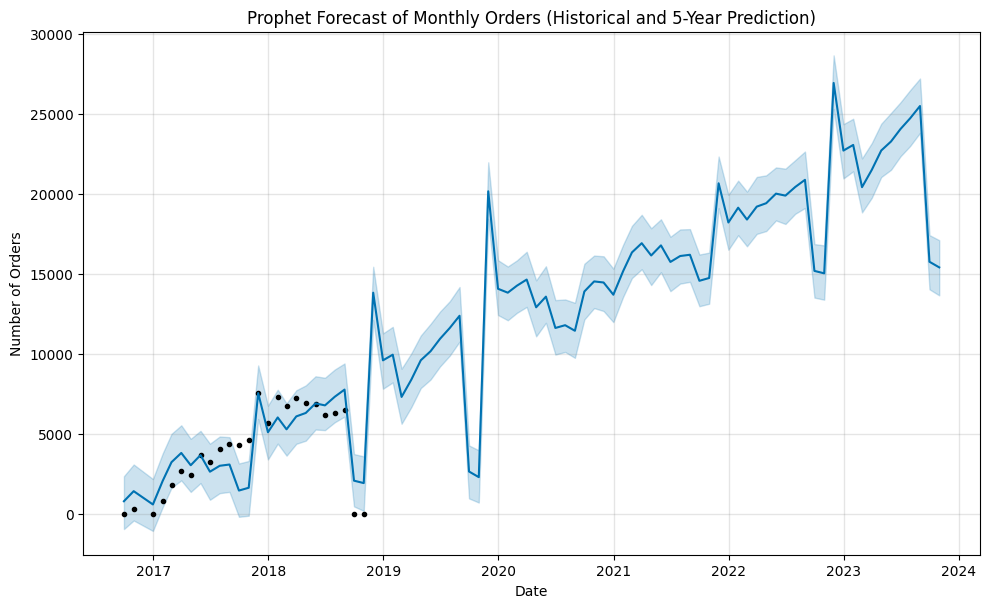

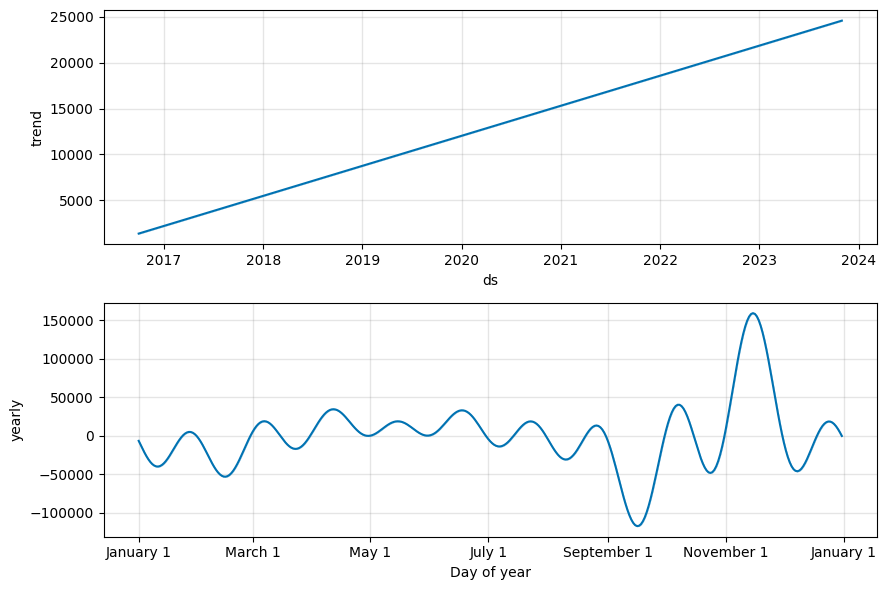

In [ ]:
# Plot the forecast
fig = model_prophet.plot(forecast_prophet)
plt.title('Prophet Forecast of Monthly Orders (Historical and 5-Year Prediction)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# You can also plot athe components of the forecast (trend, yearly seasonality)
fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()